# Conditional Entropy estimate for continuous Y
In this notebook, we repeat our algorithm (see Honest Sampling notebook) on continuous Y data.

## Sampling Code

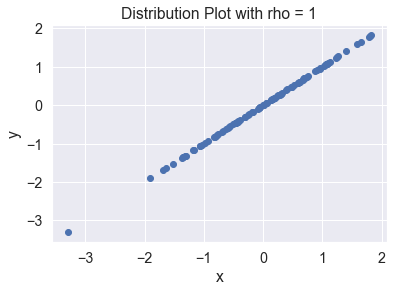

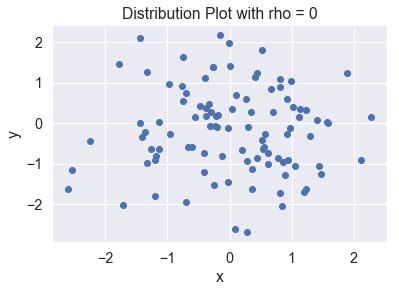

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

def get_cont_sample(n,  rho):
    x_sample = []
    y_sample = []
    means = np.zeros(2)
    cov = np.array(((1, rho), (rho, 1)))
    for i in range(n):
        x = np.random.multivariate_normal(means, cov)
        x_sample.append(x[0])
        y_sample.append(x[1])
    return x_sample, y_sample



X, y = get_cont_sample(100, 1)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X, y = get_cont_sample(100, 0)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Algorithm Development
Since our Y is continous not categorical, we can not use class probabilities as our posterior distribution. Instead, we will construct an empircal cdf from the elements in each leaf node as our conditional distribution of Y given X

In [16]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor



def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        inspect_leaf_elems(leaf_elems)
        break
    return
np.warnings.filterwarnings('ignore')

## Uncorrelated Data

In [18]:
X, y = get_cont_sample(1000, 0)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

[-1.1990068503223081, 2.284642575832161, -0.05869991193606456]
[1.54278746416022, -0.33857781655906094]
[1.3909209597499081, 0.31249268055822077]
[0.9288522274551916, -2.0583351839807267, 0.5298798009814748]
[-0.750931151366302, 0.8328629833140786]


## Correlated Data

In [24]:
X, y = get_cont_sample(1000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

[-2.2092156508113963, -2.2497065799451925]
[-1.8378391287125122, -1.8501839279413508, -1.8477815942090396, -1.846778081082956]
[-1.7280686635846751, -1.6698459295122132, -1.6628688271718093]
[-1.4667487535854065, -1.4645893697219854, -1.4746647525731955, -1.4608777056560793]
[-1.4303649825763813, -1.4328414056993812, -1.4322949436306616]


When our data is very correlated ($\rho$ = 1), we see that the elements in our leaf elements actually make sense and are close together. However, when our data is uncorrelated ($\rho$ = 0), we see that our elements are very widespread. This is exactly what we expect.

However, the count of the elements in our leaf nodes are all pretty similar. So, a naive binning strategy to create an empirical cdf will result in the same probability distribution (just 1/n for each sample point, where n is number of elements in leaf node). Thus, we need a way of incorporating the spread of our data.

We can do this by assigning a "uniform distribution" between every 2 adjacent order statistics. However, if the samples are close together, we get negaive entropy which doesn't make sense. So the overarching problem is given this blocky posterior distribution, how do I approximate the entropy?

https://en.wikipedia.org/wiki/Entropy_estimation

From the wikipedia article, since we do not know the true distribution, the way to go seems to be the histogram approimator! If we get negative entropy value, this means that our bins were too close together (very little entropoy!). Thus, I will just set that particular f(x)log(f(x)) to 0 whenever we run into this case. 


In [45]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        # initialize at 0
        entropy = 0.
        n = len(elem)
        for i in range(1, n):
            incr = (-1/n)*np.log((1/n)/(elem[i] - elem[i - 1]))
            # if valid, add probability
            if incr > 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(1000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

0.020778272387486075

In [44]:
X, y = get_cont_sample(1000, 0)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

0.33720077662944786

In [47]:
X, y = get_cont_sample(5000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 500, .32)

0.003722491154318687